# Pokémon Image Embeddings

Can you create image embeddings of Pokémon in order to compare them? Let's find out!

In [1]:
import requests
import os
from tqdm.auto import tqdm
from imgbeddings import imgbeddings
from PIL import Image
import logging
import numpy as np
import pandas as pd

logger = logging.getLogger()
logger.setLevel(logging.INFO)

Here's a compact script [modified from my AI Generated Pokémon experiments](https://github.com/minimaxir/ai-generated-pokemon-rudalle/blob/master/build_image_dataset.py) to obtain the metadata of all the normal forms of Pokémon, and download the images of the official portraits to `pokemon_images` if not already present. (roughly 30MB total)

In [2]:
folder_name = "pokemon_images"
size = 224

graphql_query = """
{
  pokemon_v2_pokemon(where: {id: {_lt: 10000}}, order_by: {id: asc}) {
    pokemon_v2_pokemontypes {
      pokemon_v2_type {
        name
      }
    }
    id
    name
  }
}
"""

image_url = (
    "https://raw.githubusercontent.com/PokeAPI/sprites/master/"
    "sprites/pokemon/other/official-artwork/{0}.png"
)

r = requests.post(
    "https://beta.pokeapi.co/graphql/v1beta",
    json={
        "query": graphql_query,
    },
)

pokemon = r.json()["data"]["pokemon_v2_pokemon"]


def encode_pokemon(p):
    return {
        "id": p["id"],
        "name": p["name"].title(),
        "type_1": p["pokemon_v2_pokemontypes"][0]["pokemon_v2_type"]["name"].title(),
    }


poke_dict = [encode_pokemon(p) for p in pokemon]

if os.path.exists(folder_name):
    print(f"/{folder_name} already exists; skipping downloading images.")
else:
    print(f"Saving Pokemon images to /{folder_name}.")
    os.makedirs(folder_name)
    for p in tqdm(pokemon):
        p_id = p["id"]
        img = Image.open(requests.get(image_url.format(p_id), stream=True).raw)
        img = img.resize((size, size), Image.ANTIALIAS)

        # https://stackoverflow.com/a/9459208
        bg = Image.new("RGB", (size, size), (255, 255, 255))
        bg.paste(img, mask=img.split()[3])
        name = f"{p_id:04d}.png"
        bg.save(os.path.join(folder_name, name))


/pokemon_images already exists; skipping downloading images.


In [3]:
ibed = imgbeddings()

Now we can generate the 768D imgbeddings for all the Pokémon.

In [4]:
# get a list of all the Pokemon image filenames
inputs = [os.path.join(folder_name, x) for x in os.listdir(folder_name)]
inputs.sort()

print(inputs[0:10])

embeddings = ibed.to_embeddings(inputs)
embeddings.shape

INFO:root:Creating image embeddings in batches of 64.


['pokemon_images/0001.png', 'pokemon_images/0002.png', 'pokemon_images/0003.png', 'pokemon_images/0004.png', 'pokemon_images/0005.png', 'pokemon_images/0006.png', 'pokemon_images/0007.png', 'pokemon_images/0008.png', 'pokemon_images/0009.png', 'pokemon_images/0010.png']


100%|██████████| 898/898 [00:20<00:00, 43.19it/s]


(898, 768)

Fit a PCA to the imgbeddings (for simplicity, we won't use any image augmentation as the Pokémon designs are already standardized), and generate the new embeddings.

In [5]:
ibed.pca_fit(embeddings, 128)

embeddings_pca = ibed.pca_transform(embeddings)
embeddings_pca.shape

INFO:root:PCA saved at "pca.npz"; provide this as `pca` to imgbeddings() to reload.
INFO:root:The fitted PCA explains 87.0% of the variance.


(898, 128)

The PCA is automatically saved as `pca.npz`; we can also save the embeddings as a separate `.npy` file and reload them for conveinence.

In [6]:
np.save("pokemon_embeddings_pca.npy", embeddings_pca)

# Pokémon Similarity Search

Let's build a `faiss` index to see which Pokémon are closest to another by visual design! (you can install faiss via `pip3 install faiss-cpu`) This approach find the Pokémon most similar using [cosine similarity](https://github.com/facebookresearch/faiss/wiki/MetricType-and-distances#how-can-i-index-vectors-for-cosine-similarity).

First, load the embeddings and build the index.

In [7]:
import faiss
from sklearn.preprocessing import normalize

from IPython.display import HTML
from io import BytesIO
import base64

INFO:faiss.loader:Loading faiss with AVX2 support.
INFO:faiss.loader:Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.


In [8]:
index = faiss.index_factory(embeddings_pca.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

index.add(normalize(embeddings_pca))
index.ntotal

898

Load a Pokémon embedding you already generated, then find the closest Pokémon! `faiss` will return the indices of the corresponding Pokemon.

Let's start with Pikachu (id `25`), and find the 10 closest Pokemon and get their similarity.

In [9]:
search_id = 25

# faiss results are zero-indexed, so must -1 when searching, +1 after retrieving
q_embedding = np.expand_dims(embeddings_pca[search_id - 1, :], 0)

# the search will return the query itself, so search for +1 result
distances, indices = index.search(normalize(q_embedding), 10 + 1)
print(indices + 1)
print(distances)


[[ 25 172 311  40  35 293 184 133 877 312  36]]
[[0.99999994 0.7427708  0.7337232  0.70968986 0.60434663 0.59117395
  0.57745117 0.5616351  0.5354088  0.5277879  0.51303416]]


ID,Name,Similarity,Image
25,Pikachu,100.0%,
172,Pichu,74.3%,
311,Plusle,73.4%,
40,Wigglytuff,71.0%,
35,Clefairy,60.4%,
293,Whismur,59.1%,
184,Azumarill,57.7%,
133,Eevee,56.2%,
877,Morpeko-Full-Belly,53.5%,
312,Minun,52.8%,

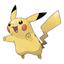
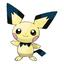
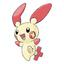
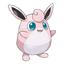
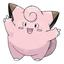
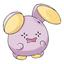
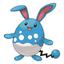
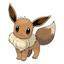
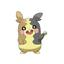
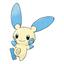
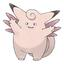

In [10]:
# https://www.kaggle.com/code/stassl/displaying-inline-images-in-pandas-dataframe/notebook

def get_thumbnail(path):
    i = Image.open(path)
    i.thumbnail((64, 64), Image.LANCZOS)
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def percent_formatter(perc):
    return f"{perc:.1%}"

data = []
for i, idx in enumerate(indices[0]):
    data.append([idx + 1, poke_dict[idx]["name"], distances[0][i], get_thumbnail(inputs[idx])])

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data, columns=["ID", "Name", "Similarity", "Image"])

HTML(df.to_html(formatters={"Image": image_formatter, "Similarity": percent_formatter}, escape=False, index=False))

To the eyes of an AI, similarity is not necessairly color; it can be shapes and curves as well. If you check other Pokémon by tweaking the `search_id` above, you'll notice that the similar images tend to have the [same stance and body features](https://twitter.com/minimaxir/status/1507166313281585164).

You can use the cell below to run your own images though the index and see what Pokémon they are most similar to!

ID,Name,Similarity,Image
—,Input Image,100.0%,
68,Machamp,51.5%,
97,Hypno,45.6%,
67,Machoke,45.1%,
70,Weepinbell,40.0%,
812,Rillaboom,39.3%,
96,Drowzee,37.6%,
765,Oranguru,36.9%,
764,Comfey,35.7%,
539,Sawk,34.2%,

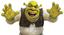
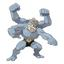
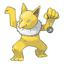
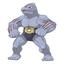
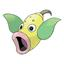
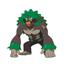
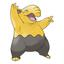
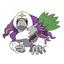
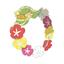
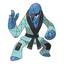
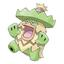

In [11]:
img_path = "/Users/maxwoolf/Downloads/shrek-facts.jpg"

img_embedding = ibed.to_embeddings(img_path)
distances, indices = index.search(normalize(img_embedding), 10)

data = [["—", "Input Image", 1, get_thumbnail(img_path)]]
for i, idx in enumerate(indices[0]):
    data.append([idx + 1, poke_dict[idx]["name"], distances[0][i], get_thumbnail(inputs[idx])])

pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data, columns=["ID", "Name", "Similarity", "Image"])

HTML(df.to_html(formatters={"Image": image_formatter, "Similarity": percent_formatter}, escape=False, index=False))